In [1]:
import numpy as np, matplotlib.pyplot as plt, networkx as nx, pickle, json, gzip
%matplotlib inline

## Set parameters

N_READS: Cutoff for the min number of reads supporting a given UMI/GFP-BC pair in a particular cell

N_UMIS: Cutoff for the min number of UMIs supporting a given cell/GFP-BC pair

N_HAMMING: Cutoff for the max hamming distance to collapse two GFP-BCs

CELL_BCS_PATH: Path to a .txt file with one cell-BC per line, corresponding to rows of the gene expression counts matrix

LIB_NAMES_PATH: Path to a .txt file with one library name per line, corresponding to rows of the gene expression counts matrix



In [2]:
N_READS = 10
N_UMIS = 3
N_HAMMING = 3
CELL_BCS_PATH = 'cell_bcs_flat.txt'
LIB_NAMES_PATH = 'samp_id_flat.txt'

## Read input files

In [3]:
cell_bcs = open(CELL_BCS_PATH).read().strip('\n').split('\n')
lib_names = open(LIB_NAMES_PATH).read().strip('\n').split('\n')

## Load data and count reads

Read in the output of step 1 (LARRY_sorting_and_filtering.py) and count the number of reads supporting each (Sample, Cell-BC, UMI, GFP-BC) combination

In [4]:
counts = {}
f = gzip.open('LARRY_sorted_and_filtered_barcodes.fastq.gz')
l = f.readline().decode("utf-8").strip('\n')
current_tag = []
i = 0
print('Reading in all barcodes')
while not (l == '' and len(current_tag)==0):
    i += 1
    if i % (3*10**6)==0: print('Processed '+repr(int(i/3))+' reads')
    if l == '':
        current_tag = []
    elif l[0] == '>':
        current_tag = l[1:].split(',')
    elif l != '' and len(current_tag)==3:
        current_tag.append(l)
        current_tag = tuple(current_tag)
        if not current_tag in counts: counts[current_tag] = 0
        counts[current_tag] += 1
        
    l = f.readline().decode("utf-8").strip('\n')

Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Processed 6000000 reads
Processed 7000000 reads
Processed 8000000 reads
Processed 9000000 reads
Processed 10000000 reads
Processed 11000000 reads
Processed 12000000 reads
Processed 13000000 reads
Processed 14000000 reads
Processed 15000000 reads
Processed 16000000 reads
Processed 17000000 reads
Processed 18000000 reads
Processed 19000000 reads
Processed 20000000 reads
Processed 21000000 reads
Processed 22000000 reads
Processed 23000000 reads
Processed 24000000 reads
Processed 25000000 reads
Processed 26000000 reads
Processed 27000000 reads
Processed 28000000 reads
Processed 29000000 reads
Processed 30000000 reads
Processed 31000000 reads
Processed 32000000 reads
Processed 33000000 reads
Processed 34000000 reads
Processed 35000000 reads
Processed 36000000 reads
Processed 37000000 reads
Processed 38000000 reads
Processed 39000000 reads
Processed 

## Filter by number of reads
Continue with analysis with (Sample, Cell-BC, UMI, GFP-BC) combinations supported by at least N_READS reads

Retaining 553571 out of 4074030 (Sample,Cell-BC,UMI,GFP-BC) combinations


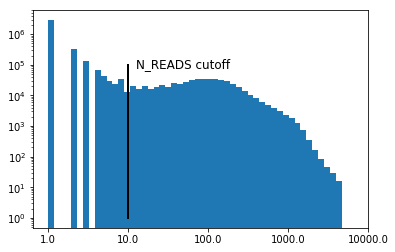

In [5]:
num_reads = [v for k,v in counts.items()]
plt.hist(np.log(num_reads)/np.log(10), bins=50)
plt.plot([np.log(N_READS)/np.log(10),np.log(N_READS)/np.log(N_READS)],[1,10**5],'-k',linewidth=2)
plt.xticks(range(5),np.logspace(0,5,6))
plt.text(np.log(N_READS)/np.log(10)*1.1,10**5*.8,'N_READS cutoff', fontsize=12)
plt.yscale('log')

counts_filtered = {k:v for k,v in counts.items() if v >= N_READS}
print('Retaining '+repr(len(counts_filtered))+ ' out of '+repr(len(counts))+' (Sample,Cell-BC,UMI,GFP-BC) combinations')

## Collapse GFP-BCs by hamming distance

In [6]:
def hamming(bc1,bc2): return np.sum([x1 != x2 for x1,x2 in zip(bc1,bc2)])

all_gfp_bcs = sorted(set([k[3] for k in counts_filtered]))
good_gfp_bcs = []
bc_map = {}
for i,bc1 in enumerate(all_gfp_bcs):
    if i > 0 and i % 500 == 0: print('Mapped '+repr(i)+' out of '+repr(len(all_gfp_bcs))+' barcodes')
    mapped = False
    for bc2 in good_gfp_bcs:
        if hamming(bc1,bc2) <= N_HAMMING:
            mapped = True
            bc_map[bc1] = bc2
            break
    if not mapped:
        good_gfp_bcs.append(bc1)

print('\nCollapsed '+repr(len(bc_map))+' barcodes')
for bc in good_gfp_bcs: bc_map[bc] = bc

Mapped 500 out of 5152 barcodes
Mapped 1000 out of 5152 barcodes
Mapped 1500 out of 5152 barcodes
Mapped 2000 out of 5152 barcodes
Mapped 2500 out of 5152 barcodes
Mapped 3000 out of 5152 barcodes
Mapped 3500 out of 5152 barcodes
Mapped 4000 out of 5152 barcodes
Mapped 4500 out of 5152 barcodes
Mapped 5000 out of 5152 barcodes

Collapsed 1373 barcodes


## Filter GFP-barcodes by UMI
Index (UMI, GFP-BC) combinations to cells, then filter out BCs supported by fewer than N_UMIS UMIs


Final annotation has 2769 clones in 13303 cells


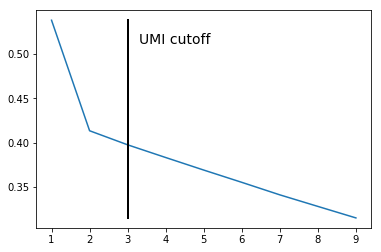

In [7]:
cell_data = {}
for lib,cell in zip(lib_names,cell_bcs):
    cell_data[(lib,cell)] = {}

for lib,cell,umi,BC in counts_filtered.keys():
    if (lib,cell) in cell_data:
        if not BC in cell_data[(lib,cell)]:
            cell_data[(lib,cell)][BC] = 0
        cell_data[(lib,cell)][BC] += 1

BC_lists = []
for i in range(1,10):
    BC_list = []
    for lib,cell in zip(lib_names,cell_bcs):
        bc_counts = cell_data[(lib,cell)]
        valid_bcs = [bc_map[k] for k,v in bc_counts.items() if v >= i]
        BC_list.append(''.join(sorted(valid_bcs)))
    BC_lists.append(BC_list)

efficiency = np.array([len([ll for ll in l if len(ll)>0]) for l in BC_lists]) / len(cell_bcs)
plt.plot(range(1,10),efficiency)
plt.plot([N_UMIS,N_UMIS],[np.min(efficiency),np.max(efficiency)],'-k',linewidth=2)
plt.text(N_UMIS*1.1,np.max(efficiency)*.95,'UMI cutoff',fontsize=14)

final_BCs = BC_lists[N_UMIS-1]
print('\nFinal annotation has '+repr(len(set(final_BCs)))+' clones in '+repr(len([l for l in final_BCs if len(l)>0]))+' cells')

## Outout clonal anotations
There are three output files: 
- clone_mat.csv
- clone_mat.npy
- barcode_list.txt

The two clone_mat files store a binary matrix where rows are cells and columns are clones. A "1" at entry (i,j) indicates that cell i belongs to clone j. The barcode_list file stores the barcode for each cell. Two barcode strings separated by an underscore indicates that the cell contains multiple barcodes. An empty line implies no barcode for that cell.

In [8]:
BC_set = sorted(set([bc for bc in final_BCs if bc != '']))
clone_mat = np.zeros((len(final_BCs),len(BC_set)))
for i,bc in enumerate(final_BCs):
    if bc != '':
        j = BC_set.index(bc)
        clone_mat[i,j] = 1
clone_mat = np.array(clone_mat,dtype=int)
np.savetxt('clone_mat.csv',clone_mat,delimiter=',',fmt='%i');
np.save('clone_mat.npy',clone_mat);
open('barcode_list.txt','w').write('\n'.join(final_BCs));